In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Predicting customer churn with feed-forward neural networks

Adrian Alarcon

### Data preprocessing

In [46]:
### Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from utils import *
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, recall_score,precision_score
import warnings
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')

In [3]:
### Obtain data

data = pd.read_csv('data/Customer Churn.csv')
print(data.shape)
data.columns = [col.lower() for col in data.columns]
data.head()

(3150, 16)


,call failure,complains,subscription length,charge amount,seconds of use,frequency of use,frequency of sms,distinct called numbers,age group,tariff plan,status,age,customer value,fn,fp,churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,177.8760,69.7640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,41.4315,60.0000,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,1382.8680,203.6520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,216.0180,74.0020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,131.2245,64.5805,0


### Exploratory data analysis

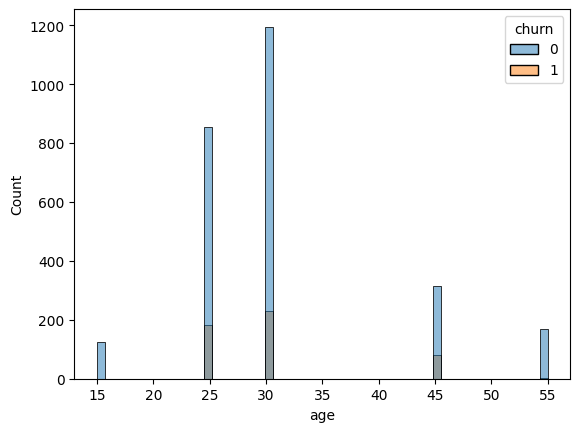

In [4]:
sns.histplot(data, x = 'age', hue = 'churn')
plt.show()

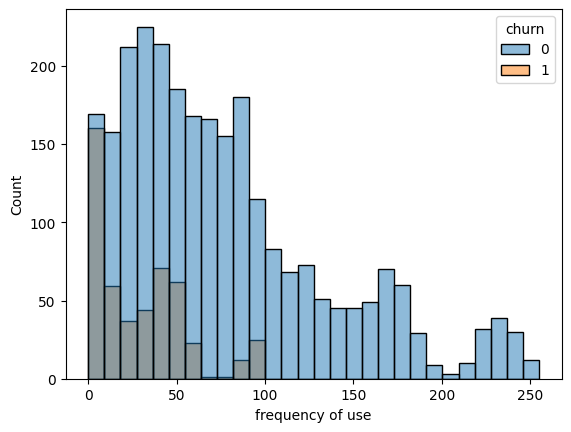

In [5]:
sns.histplot(data, x = 'frequency of use', hue = 'churn')
plt.show()

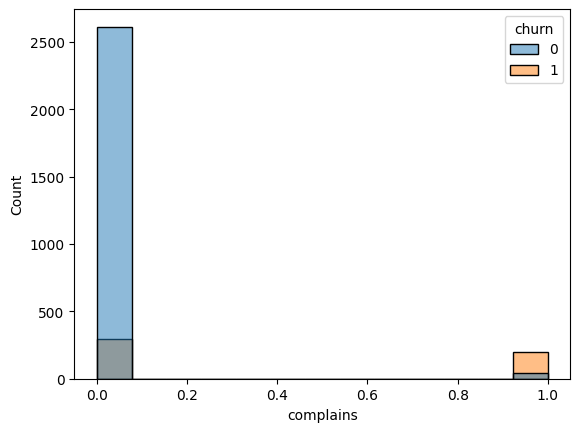

In [6]:
sns.histplot(data, x = 'complains', hue = 'churn')
plt.show()

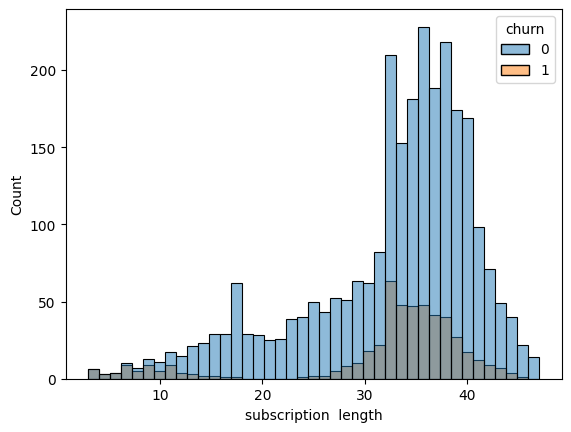

In [7]:
sns.histplot(data, x = 'subscription  length', hue = 'churn')
plt.show()

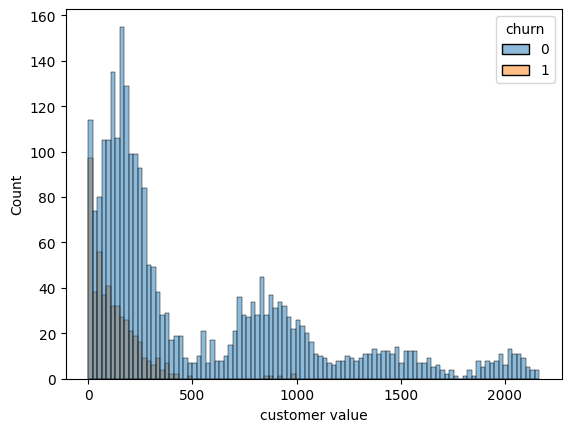

In [8]:
sns.histplot(data, x = 'customer value', hue = 'churn', bins = 100)
plt.show()

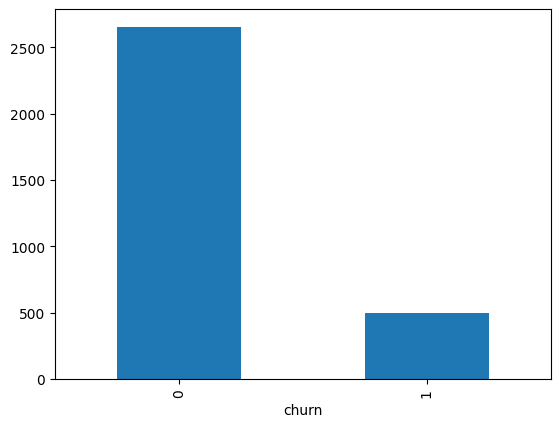

In [9]:
data['churn'].value_counts().plot(kind = 'bar') 
plt.show() 

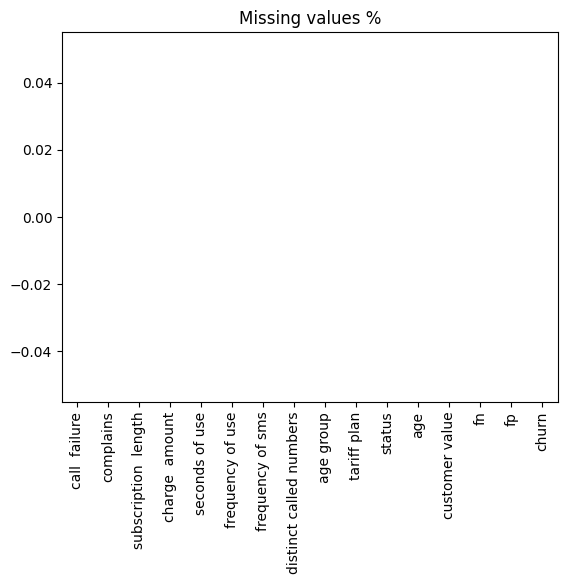

In [10]:
data.isna().mean().plot(kind = 'bar')
plt.title('Missing values %')
plt.show()

### Split datasets


In [11]:
VARS = [
    'call  failure', 
    'complains', 
    #'subscription  length', 
    'charge  amount',
    'seconds of use', 
    #'frequency of use', 
    'frequency of sms',
    'distinct called numbers', 
    'age group', 
    'tariff plan', 
    #'status', 
    'age',
    'customer value'
    ]
TARGET = ['churn']

x = data[VARS]
y = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)
x_fit , x_val, y_fit, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 123)
print('Shape of train:', x_fit.shape)
print('Shape of validation:', x_val.shape)
print('Shape of test:', x_test.shape)

Shape of train: (2016, 10)
Shape of validation: (504, 10)
Shape of test: (630, 10)


In [12]:
### Scaling

esc = MinMaxScaler()
x_fit_esc = esc.fit_transform(x_fit)
x_val_esc = esc.transform(x_val)
x_test_esc = esc.transform(x_test)


### Modeling

In [13]:
nshape = x_fit_esc.shape[1]

#### First experiment

Base model with 2 hidden layers

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8519 - auc: 0.6595 - f1_score: 0.1194 - loss: 0.4495 - val_accuracy: 0.9127 - val_auc: 0.9207 - val_f1_score: 0.6140 - val_loss: 0.2404
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.8954 - auc: 0.9170 - f1_score: 0.5343 - loss: 0.2453 - val_accuracy: 0.9048 - val_auc: 0.9245 - val_f1_score: 0.6129 - val_loss: 0.2227
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.8992 - auc: 0.9108 - f1_score: 0.5717 - loss: 0.2458 - val_accuracy: 0.9087 - val_auc: 0.9233 - val_f1_score: 0.6102 - val_loss: 0.2212
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.9106 - auc: 0.9318 - f1_score: 0.6479 - loss: 0.2184 - val_accuracy: 0.8988 - val_auc: 0.9253 - val_f1_score: 0.5854 - val_loss: 0.2202
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.9075 - auc: 0.9271 - f1_score: 0.6232 - loss: 0.2226 - val_accuracy: 0.9087 - val_auc: 0.9255 - val_f1_score: 0.6102 - val_

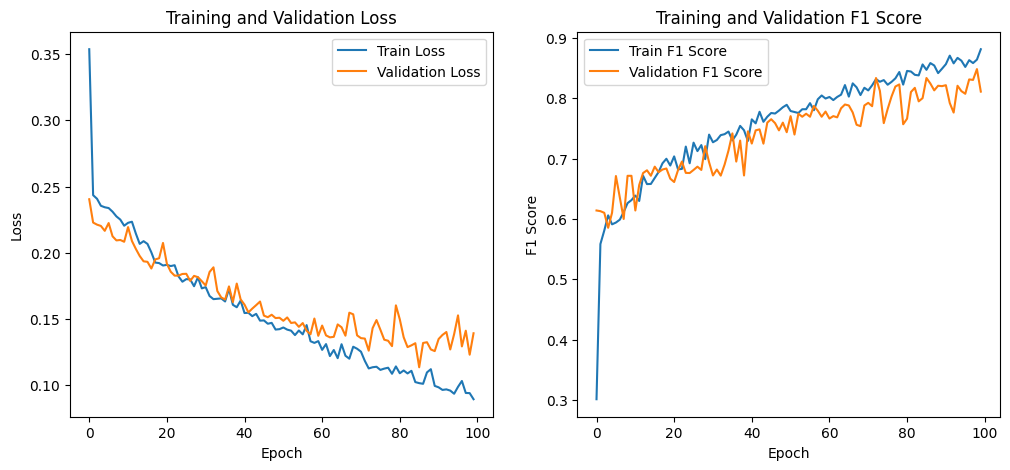

In [14]:
K.clear_session()
model = Sequential([
    layers.Dense(128, activation='relu', input_shape=(nshape,)),
    layers.Dense(128, activation='relu'), 
    layers.Dense(48, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc'), F1Score()])

history = model.fit(x_fit_esc, y_fit, epochs=100, batch_size=32, validation_data=(x_val_esc, y_val))
plot_val_train_loss(history)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


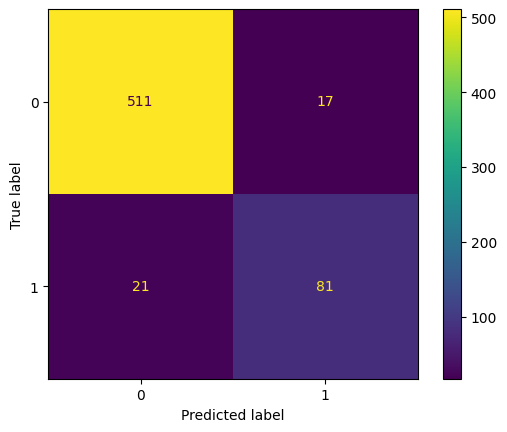

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


In [47]:
threshold = 0.5
model1_results = get_metrics(model, x_test_esc, y_test, threshold)

#### Second experiment

Base model with 2 hidden layers and 2 dropout layers

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7908 - auc: 0.6541 - f1_score: 0.1275 - loss: 0.4644 - val_accuracy: 0.9127 - val_auc: 0.9185 - val_f1_score: 0.6140 - val_loss: 0.2420
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.8915 - auc: 0.9079 - f1_score: 0.5443 - loss: 0.2615 - val_accuracy: 0.9127 - val_auc: 0.9220 - val_f1_score: 0.6140 - val_loss: 0.2218
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.8897 - auc: 0.9139 - f1_score: 0.5681 - loss: 0.2567 - val_accuracy: 0.9127 - val_auc: 0.9189 - val_f1_score: 0.6140 - val_loss: 0.2245
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.8915 - auc: 0.9044 - f1_score: 0.5037 - loss: 0.2542 - val_accuracy: 0.9067 - val_auc: 0.9256 - val_f1_score: 0.6050 - val_loss: 0.2182
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.9148 - auc: 0.9280 - f1_score: 0.6039 - loss: 0.2112 - val_accuracy: 0.9048 - val_auc: 0.9260 - val_f1_score: 0.6000 - val_

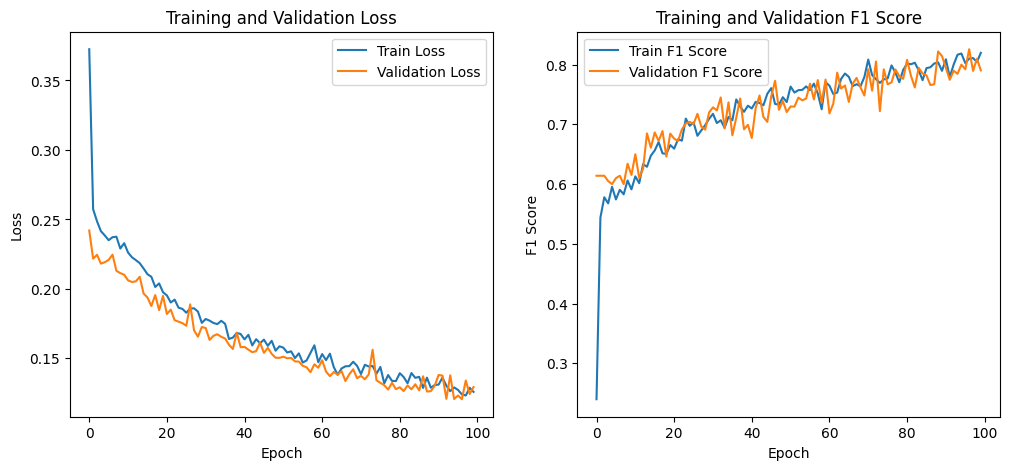

In [16]:
K.clear_session()
model2 = Sequential([
    layers.Dense(128, activation='relu', input_shape=(nshape,)),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'), 
    layers.Dropout(0.2),
    layers.Dense(48, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

model2.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc'), F1Score()])

history = model2.fit(x_fit_esc, y_fit, epochs=100, batch_size=32, validation_data=(x_val_esc, y_val))
plot_val_train_loss(history)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


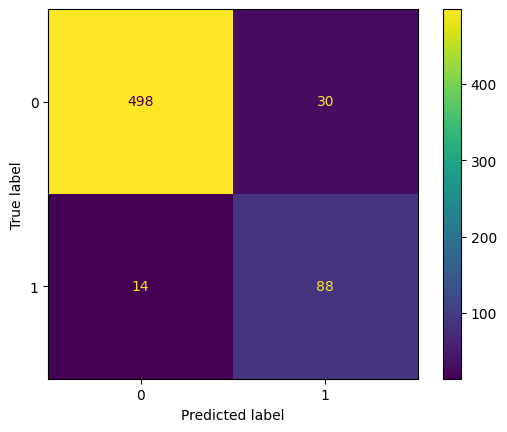

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


In [48]:
threshold = 0.5
model2_results = get_metrics(model2, x_test_esc, y_test, threshold)

#### Third experiment

Added more hidden layers, more epochs and early stopping

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8300 - auc: 0.5596 - f1_score: 0.0792 - loss: 0.4481 - val_accuracy: 0.9127 - val_auc: 0.9216 - val_f1_score: 0.6140 - val_loss: 0.2622
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8853 - auc: 0.9202 - f1_score: 0.5053 - loss: 0.2731 - val_accuracy: 0.9127 - val_auc: 0.9237 - val_f1_score: 0.6140 - val_loss: 0.2556
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9007 - auc: 0.9277 - f1_score: 0.5703 - loss: 0.2591 - val_accuracy: 0.9127 - val_auc: 0.9255 - val_f1_score: 0.6140 - val_loss: 0.2556
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8984 - auc: 0.9122 - f1_score: 0.5584 - loss: 0.2714 - val_accuracy: 0.9107 - val_auc: 0.9249 - val_f1_score: 0.6512 - val_loss: 0.2598
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8956 - auc: 0.9195 - f1_score: 0.5444 - loss: 0.2555 - val_accuracy: 0.9107 - val_auc: 0.9274 - val_f1_score: 0.6154 - val_loss: 0.

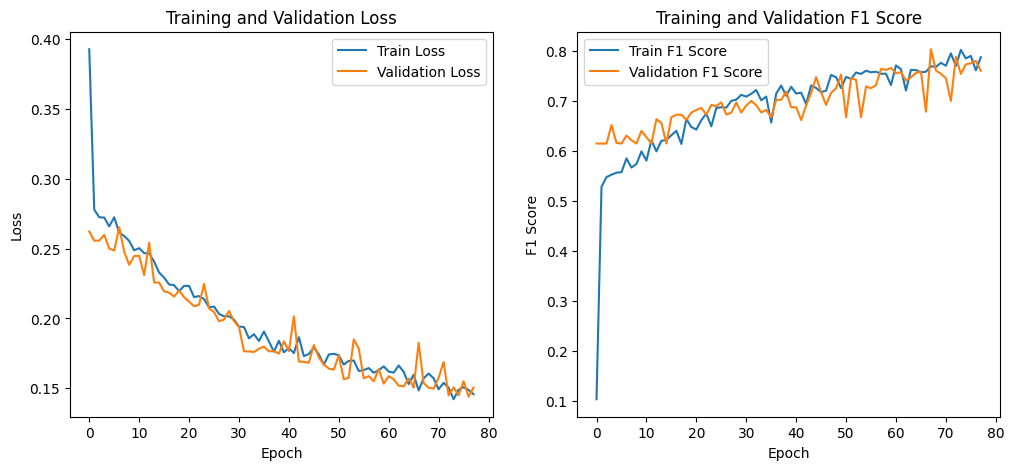

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
K.clear_session()
model3 = Sequential([
    layers.Dense(128, activation='relu', input_shape=(nshape,)),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'), 
    layers.Dense(1024, activation='sigmoid'), 
    #layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(48, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

early_stopping = EarlyStopping(monitor='val_f1_score', patience=10, mode='max', restore_best_weights=True)

model3.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc'), F1Score()]
              )

history = model3.fit(x_fit_esc, 
                     y_fit, 
                     epochs=500, 
                     batch_size=32, 
                     validation_data=(x_val_esc, y_val),
                     callbacks=[early_stopping])
plot_val_train_loss(history)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step


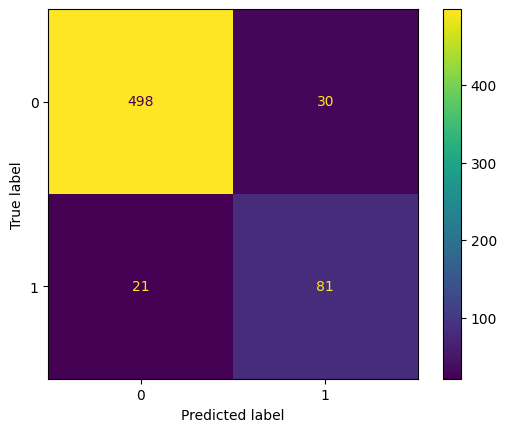

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step


In [49]:
threshold = 0.5
model3_results = get_metrics(model3, x_test_esc, y_test, threshold)

#### Fourth experiment

Base architecture with more neurons and early stopping

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8355 - auc: 0.6830 - f1_score: 0.0873 - loss: 0.4645 - val_accuracy: 0.9127 - val_auc: 0.9172 - val_f1_score: 0.6140 - val_loss: 0.2309
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.8863 - auc: 0.9120 - f1_score: 0.5241 - loss: 0.2607 - val_accuracy: 0.9067 - val_auc: 0.9234 - val_f1_score: 0.6050 - val_loss: 0.2216
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.9111 - auc: 0.9193 - f1_score: 0.6021 - loss: 0.2295 - val_accuracy: 0.9028 - val_auc: 0.9247 - val_f1_score: 0.5950 - val_loss: 0.2203
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.8935 - auc: 0.9210 - f1_score: 0.5877 - loss: 0.2421 - val_accuracy: 0.9147 - val_auc: 0.9252 - val_f1_score: 0.6261 - val_loss: 0.2201
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.9067 - auc: 0.9232 - f1_score: 0.6171 - loss: 0.2330 - val_accuracy: 0.9147 - val_auc: 0.9264 - val_f1_score: 0.6261 - val_

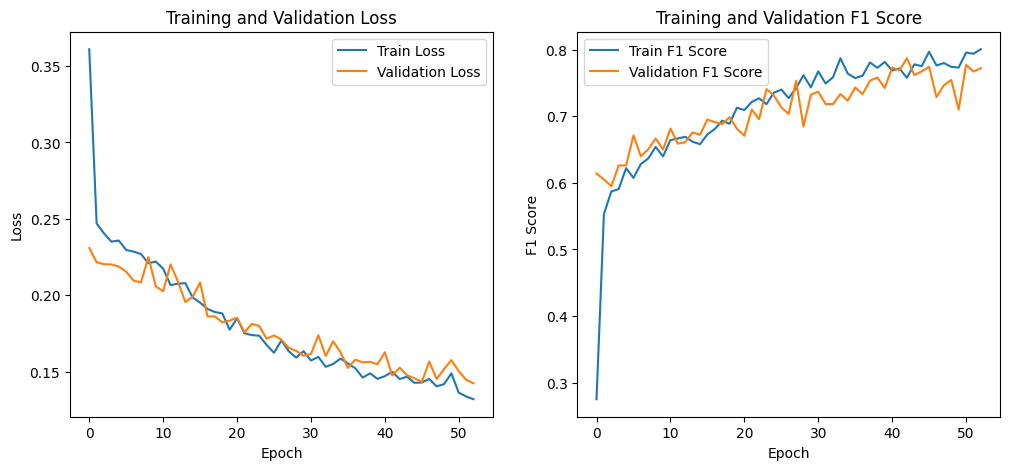

In [20]:
K.clear_session()
model4 = Sequential([
    layers.Dense(128, activation='relu', input_shape=(nshape,)),
    layers.Dense(128, activation='relu'), 
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])
early_stopping = EarlyStopping(monitor='val_f1_score', patience=10, mode='max', restore_best_weights=True)
model4.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc'), F1Score()])

history = model4.fit(x_fit_esc, 
                     y_fit, 
                     epochs=500, 
                     batch_size=32, 
                     validation_data=(x_val_esc, y_val), 
                     callbacks=[early_stopping])
plot_val_train_loss(history)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


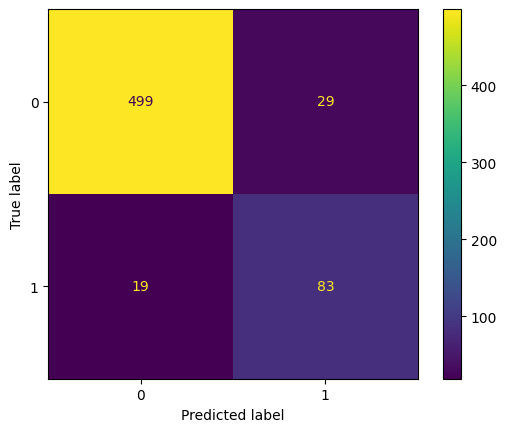

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


In [50]:
threshold = 0.5
model4_results = get_metrics(model4, x_test_esc, y_test, threshold)

#### Fifth experiment

Base architecture with early stopping

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8357 - auc: 0.6592 - f1_score: 0.0813 - loss: 0.4847 - val_accuracy: 0.9127 - val_auc: 0.9196 - val_f1_score: 0.6140 - val_loss: 0.2326
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.8973 - auc: 0.9051 - f1_score: 0.5476 - loss: 0.2554 - val_accuracy: 0.9048 - val_auc: 0.9241 - val_f1_score: 0.6129 - val_loss: 0.2282
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.8879 - auc: 0.9153 - f1_score: 0.5621 - loss: 0.2549 - val_accuracy: 0.9127 - val_auc: 0.9239 - val_f1_score: 0.6207 - val_loss: 0.2198
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.9054 - auc: 0.9143 - f1_score: 0.6030 - loss: 0.2433 - val_accuracy: 0.8988 - val_auc: 0.9282 - val_f1_score: 0.6792 - val_loss: 0.2345
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.9034 - auc: 0.9288 - f1_score: 0.6133 - loss: 0.2285 - val_accuracy: 0.9147 - val_auc: 0.9246 - val_f1_score: 0.6261 - val_

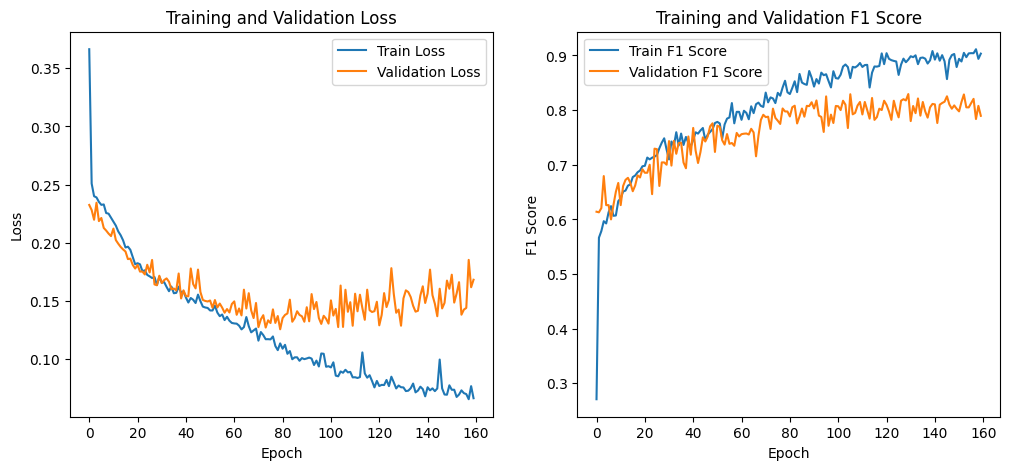

In [22]:
K.clear_session()
model5 = Sequential([
    layers.Dense(128, activation='relu', input_shape=(nshape,)),
    layers.Dense(128, activation='relu'), 
    layers.Dense(48, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])
early_stopping = EarlyStopping(monitor='val_f1_score', patience=30, mode='max', restore_best_weights=True)
model5.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc'), F1Score()])

history = model5.fit(x_fit_esc, 
                    y_fit, 
                    epochs=500, 
                    batch_size=32, 
                    validation_data=(x_val_esc, y_val),
                    callbacks=[early_stopping])
plot_val_train_loss(history)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


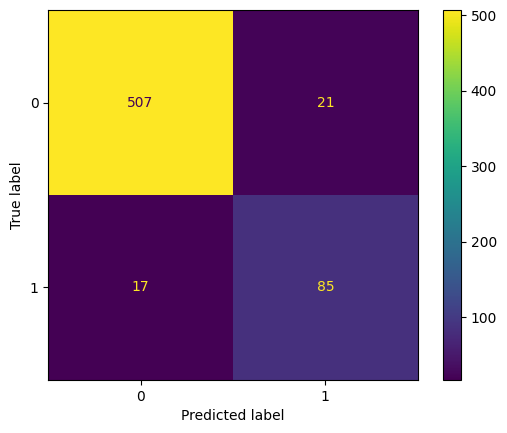

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


In [51]:
threshold = 0.5
model5_results = get_metrics(model5, x_test_esc, y_test, threshold)

#### Model comparison

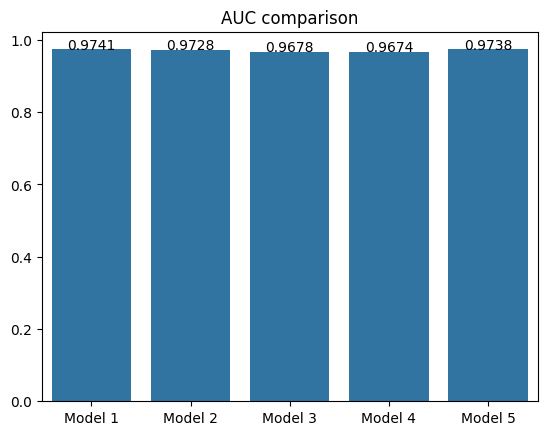

In [52]:
results= [
    model1_results,
    model2_results,
    model3_results,
    model4_results,
    model5_results
]

labels = [
    'Model 1',
    'Model 2',
    'Model 3',
    'Model 4',
    'Model 5'

]

auc_results = []

for i in results:
    auc_results.append(i['AUC'])


sns.barplot(x = labels, y = auc_results)
for i in range(len(auc_results)):
    
    plt.text(x = i, y = auc_results[i], s = round(auc_results[i], 4), ha = 'center')
plt.title('AUC comparison')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


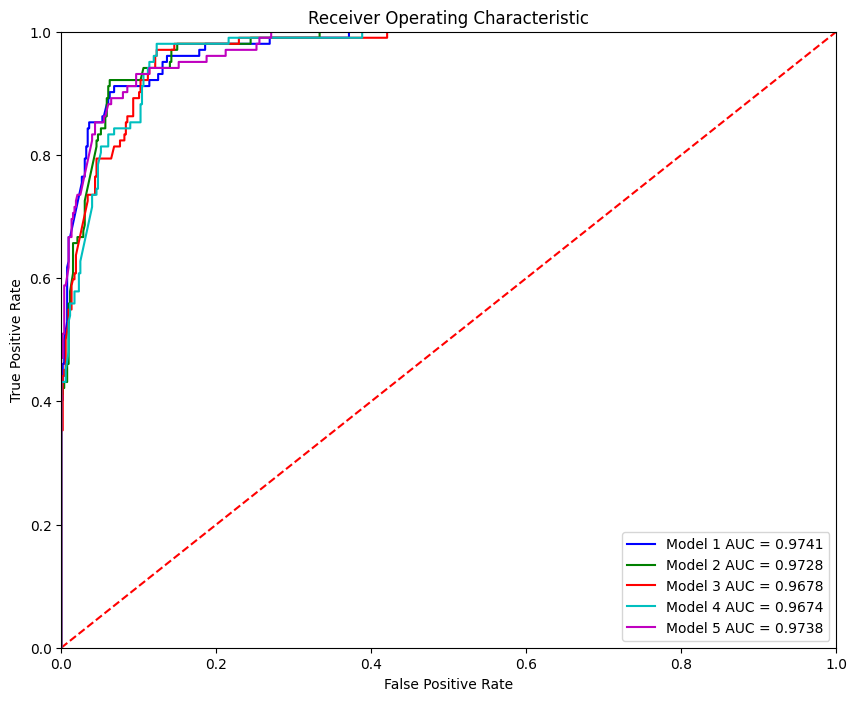

In [53]:
plot_roc_curves(x_test_esc, y_test, [model, model2, model3, model4, model5])

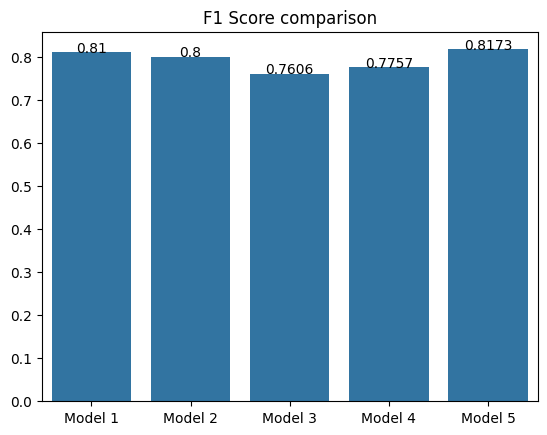

In [34]:
f1_results = []

for i in results:
    f1_results.append(i['F1 Score'])


sns.barplot(x = labels, y = f1_results)
for i in range(len(f1_results)):

    plt.text(x = i, y = f1_results[i], s = round(f1_results[i], 4), ha = 'center')
plt.title('F1 Score comparison')
plt.show()

## Report

This report provides a detailed overview of a series of experiments conducted to predict customer churn using feed-forward neural networks. Each experiment aimed to optimize model performance through variations in neural network architecture, training procedures, and validation strategies. The [dataset](https://www.kaggle.com/datasets/royjafari/customer-churn) used in these experiments comprises customer data, including features like age, frequency of use, and other relevant attributes linked to customer churn.

**Data preprocessing**

* Data Cleaning: Handling missing values, correcting data types, and removing duplicates. This ensures that the data fed into the model is accurate and consistent. There were no missing values on the dataset.
* Normalization/Standardization: Scaling numerical features to ensure that the model is not biased towards variables with larger scales, and to ensure neural network do not give more weight to variables with higher scales

**Exploratory Data Analysis (EDA)**

EDA is essential for understanding the distribution and relationships of variables within the dataset. Visualizations such as histograms help identify patterns, anomalies, or relationships between features, providing insights into the data that can inform subsequent modeling decisions. On the current dataset we can see that number of complaints may be agood predictor for churn. Additionally, we are in front of an umbalanced problem since there are more no churn cases compared with the churn cases.

**Validation strategy**

To validate the predictive power of the model and prevent overfitting, we have used thre datasets:

* Shape of train: (2016, 10)
* Shape of validation: (504, 10)
* Shape of test: (630, 10)

**Training**

To prevent data leakage, only variables not related with purchase behaviour have been selected. The variables considered are: 

`VARS = [
    'call  failure', 
    'complains', 
    'charge  amount',
    'seconds of use', 
    'frequency of sms',
    'distinct called numbers', 
    'age group', 
    'tariff plan', 
    'age',
    'customer value'
  ]`


**Experimentation**

The experiments explored various configurations of neural networks to identify the most effective architecture for predicting customer churn:

1. First Experiment: A base model with two hidden layers was used as a starting point to establish a benchmark for performance.
2. Second Experiment: Introduction of dropout layers to the base model to prevent overfitting and improve model generalizability.
3. Third Experiment: Increased complexity by adding more hidden layers and using more training epochs alongside early stopping to refine training duration based on validation loss improvements.
4. Fourth Experiment: Enhanced the base model by increasing the number of neurons in each layer to capture more complex patterns in the data.
5. Fifth Experiment: Simplification strategy focusing on early stopping to prevent overfitting while maintaining a relatively simpler network architecture.

**Results**

Based on AUC only, the best experiment was first experiment with 0.9741, and the second one was experiment 5 with 0.9736. Considering F1 Score the best model was experiment 5 with 0.8173, and the second one was experiment 1 with 0.81. This can changed since we have considered 0.5 as threshold for all the experiments

**Findings**

One interesting finding was that when dealing with tabluar data, simpler neural networks architectures are more accurate, and `relu` showed a better performance rather than other activation function. Additionally, dropout layers helped to prevent overfitting but the most effective technique to prevent that was early stopping rounds

**Next steps**

To increase the performance of the model, first it is possible to try with a `softmax` activation function on the output. To do this, `yfit` should change and one hot encoding should be applied to get 2 outputs instead of 2. Additionally,  threshold optimization can be performed using different techniques such as precision-recall optimization or Youden index. This would not affect AUC but the other metrics. Finally, it is important to perform some feature engineering to capture trends that the current variables do not.